In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cv2

import os

from obtain_thresholds import read_img_data_from_disk, k_fold_cross_validation
from Localization import plate_detection

In [2]:
X = read_img_data_from_disk('./dataset/ColourVariations')

randomise = np.arange(X.shape[0])
X = X[randomise]

In [ ]:
X.shape

In [ ]:
k_fold_cross_validation(X, 5, 3)

In [ ]:
df = pd.read_csv('./dataset/bounding_boxes.csv')

In [ ]:
category_1 = df.iloc[:32]
path = './dataset/Frames/Category_I/'
avg_intersection_over_union_i = 0

for i in range(32):
    row = category_1.iloc[i]
    bounding_box = BoundingBox(row['Left'], row['Top'], row['Right'], row['Bottom'])

    frame = cv2.imread(path + row['Image'])
    plates = plate_detection(frame)

    if len(plates[1]):
        avg_intersection_over_union_i += (bounding_box.intersection_over_union(plates[1][0]))
print(f'Detected correctly Category I: {avg_intersection_over_union_i / 32}')

In [ ]:
category_2 = df.iloc[32:60]
path = './dataset/Frames/Category_II/'
avg_intersection_over_union_ii = 0

for i in range(28):
    row = category_2.iloc[i]
    bounding_box = BoundingBox(row['Left'], row['Top'], row['Right'], row['Bottom'])

    frame = cv2.imread(path + row['Image'])
    plates = plate_detection(frame)

    if len(plates[1]):
        avg_intersection_over_union_ii += (bounding_box.intersection_over_union(plates[1][0]))
print(f'Detected correctly Category II: {avg_intersection_over_union_ii / 28}')

In [ ]:
category_3 = df.iloc[60:]
path = './dataset/Frames/Category_III/'
avg_intersection_over_union_iii = 0

for i in range(0, 10, 2):
    row_1 = category_3.iloc[i]
    row_2 = category_3.iloc[i+1]

    bounding_box_1 = BoundingBox(row_1['Left'], row_1['Top'], row_1['Right'], row_1['Bottom'])
    bounding_box_2 = BoundingBox(row_2['Left'], row_2['Top'], row_2['Right'], row_2['Bottom'])

    frame = cv2.imread(path + row_1['Image'])
    plates = plate_detection(frame)

    if len(plates[1]) == 1:
        b1 = bounding_box_1.intersection_over_union(plates[1][0])
        b2 = bounding_box_2.intersection_over_union(plates[1][0])

        if b1 < b2:
            b1 = b2

        avg_intersection_over_union_iii += b1
    elif len(plates[1]) == 2:
        b1 = bounding_box_1.intersection_over_union(plates[1][0])
        b2 = bounding_box_2.intersection_over_union(plates[1][0])
        b3 = bounding_box_1.intersection_over_union(plates[1][1])
        b4 = bounding_box_2.intersection_over_union(plates[1][1])

        op1 = b1
        op2 = b2

        if b3 > op1:
            op1 = b3

        if b4 > op2:
            op2 = b4

        avg_intersection_over_union_iii += op2 + op1
print(f'Detected correctly Category III: {avg_intersection_over_union_iii / 10}')

In [37]:
from pre_processing_data import process_raw_data_for_characters, put_margin, reshape_img
from character_recognition import calculate_perimeter_area_vector, recognise_character, give_label_lowest_score
from Recognize import segment
from kd_tree import KDTree, HeapEntry

In [35]:
directory_path = './dataset/CharactersDataset/TrainingSet/'

dataset = []

folders = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

for folder in folders:
  folder_path = directory_path + '/' + folder
  files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

  for file_name in files:
    img = 255 - cv2.imread(folder_path + '/' + file_name, cv2.IMREAD_GRAYSCALE)
    reshaped_img = reshape_img(img)

    p = calculate_perimeter_area_vector(reshaped_img)

    dataset.append(HeapEntry(0, p, reshaped_img, folder[0]))
# train_data = process_raw_data_for_characters('./dataset/CharactersDataset/TrainingSet')
# test_data = process_raw_data_for_characters('./dataset/CharactersDataset/TestSet')

In [7]:
kdtree = KDTree()
for entry in train_data:
    kdtree.insert_point(entry[1], entry[2], entry[0])

In [8]:
recognise_character(kdtree, test_data[40][2], 20)

'1'

In [9]:
test_data[40]

('1',
 array([71.65685415, 65.        ]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [10]:
with open('./hyperparameters/kdtree.pickle', 'wb') as handle:
    pickle.dump(kdtree, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
with open('./hyperparameters/kdtree.pickle', 'rb') as handle:
    kdtree = pickle.load(handle)

In [31]:
frame = cv2.imread('./dataset/binPlates/Category_I/plate5.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame[frame >= 125] = 255
frame[frame < 125] = 0

segments = segment(frame, binary=True)

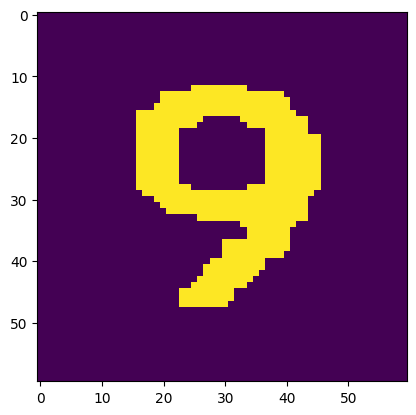

9


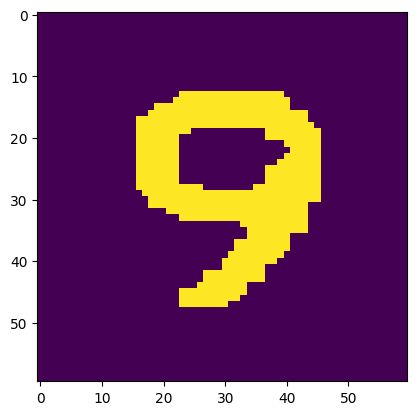

9


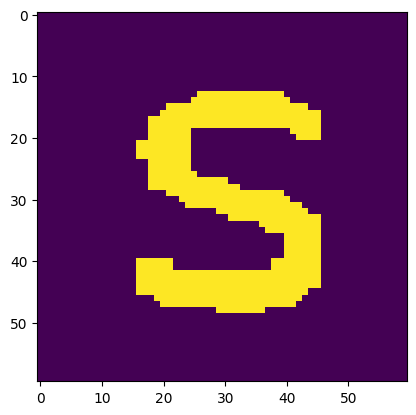

S


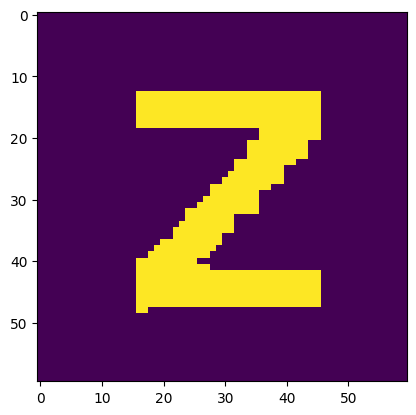

Z


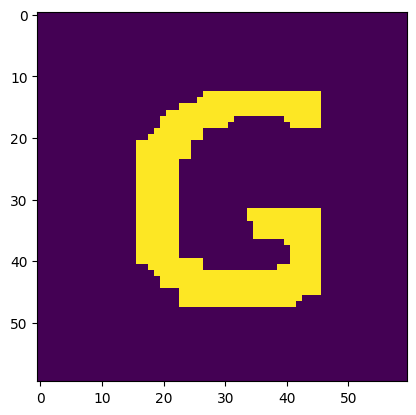

C


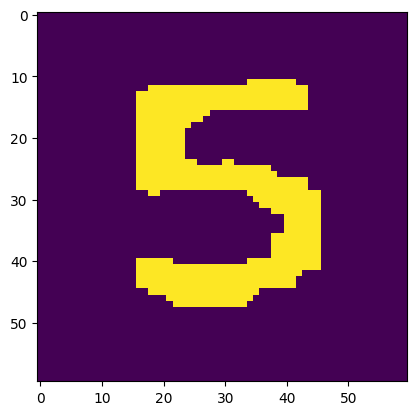

5


In [40]:
for s in segments:
    resized_img = cv2.resize(s, (30, 45), interpolation = cv2.INTER_LINEAR)
    margined_img = put_margin(resized_img, 0, 0, 29, 44)
    margined_img[margined_img >= 125] = 255
    margined_img[margined_img < 125] = 0

    plt.imshow(margined_img)
    plt.show()

    give_label_lowest_score(margined_img, dataset)

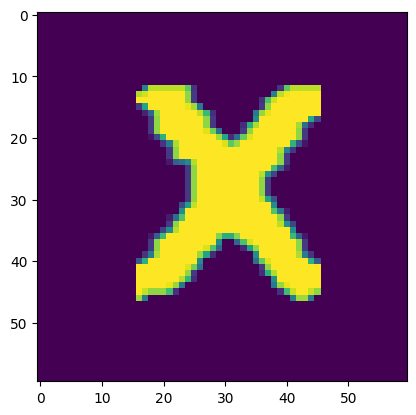

In [33]:
plt.imshow(margined_img)